# 单车预测器_第二版
### 比第一版增加了保存模型的功能

## 1. 模块导入

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

## 2. 导入数据

In [2]:
data_path = './bike-sharing-dataset/hour.csv'
rides = pd.read_csv(data_path)

## 3. 数据预处理

In [3]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)
    
fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)

quant_feature = ['cnt', 'temp', 'hum', 'windspeed']

scaled_features = {}
for each in quant_feature:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean) / std

test_data = data[-21 * 24:]
train_data = data[:-21 * 24]

target_fields = ['cnt', 'casual', 'registered']

features, targets = train_data.drop(target_fields, axis=1), train_data[target_fields]

test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

X = features.values

Y = targets['cnt'].values
Y = Y.astype(float)
Y = np.reshape(Y, [len(Y), 1])

#测试数据----------------------------------------------------------------------------------
targets = test_targets['cnt']  #读取测试集的cnt数值
targets = targets.values.reshape([len(targets), 1])  #将数据转换成合适的tensor形式
targets = targets.astype(float)  #保证数据为实数
#------------------------------------------------------------------------------------------

## 4. 模型搭建

In [7]:
input_size=features.shape[1]
hidden_size=10
output_size = 1
batch_size = 128

tf_x = tf.placeholder(tf.float32, shape=(None, input_size), name='x_input')  # input x
tf_y = tf.placeholder(tf.float32, shape=(None, output_size), name='y_input')  # input y

# neural network layers
l1 = tf.layers.dense(tf_x, hidden_size, tf.nn.sigmoid)  # hidden layer
output = tf.layers.dense(l1, output_size)  # output layer

loss = tf.compat.v1.losses.mean_squared_error(tf_y, output)  # compute cost
optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=0.001)
train_op = optimizer.minimize(loss)

## 5. 训练

In [5]:
#train------------------------------------------------------------------------------------
saver = tf.compat.v1.train.Saver()  # define a saver for saving and restoring
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())  # initialize var in graph

    for step in range(1000):
        # training
        for start in range(0, len(X), batch_size):
            end = start + batch_size if start + batch_size < len(X) else len(X)
            _, loss_value = sess.run([train_op, loss], feed_dict={tf_x: X[start:end], tf_y: Y[start:end]})
        if step % 100 == 0:
            print("steps:", step, "loss:", loss_value)
    
    saver.save(sess, '20200318_1/model.ckpt')  # meta_graph is not recommended

steps: 0 loss: 0.8433535
steps: 100 loss: 0.5817232
steps: 200 loss: 0.37646353
steps: 300 loss: 0.30319175
steps: 400 loss: 0.28296354
steps: 500 loss: 0.27384648
steps: 600 loss: 0.26783505
steps: 700 loss: 0.2632146
steps: 800 loss: 0.2593764
steps: 900 loss: 0.25613979


# 6. 删除之前的图（十分重要，卡了几次都是这个问题）

In [6]:
tf.reset_default_graph()

## 7. 重新搭建模型（重复操作4）

## 8. 载入保存好的模型

INFO:tensorflow:Restoring parameters from 20200318_1/model.ckpt


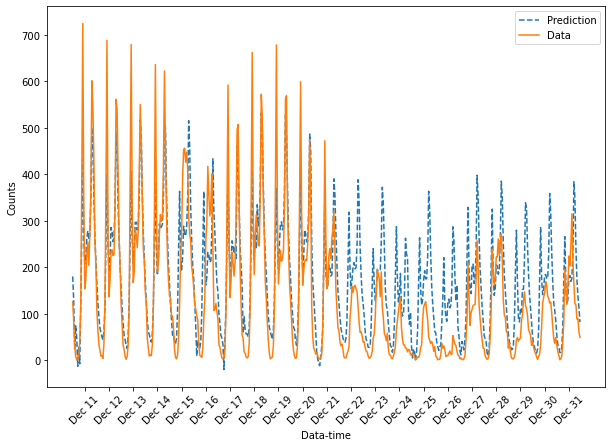

In [10]:
with tf.compat.v1.Session() as sess:
    saver = tf.compat.v1.train.Saver()
    saver.restore(sess,'20200318_1/model.ckpt')  
    predict = sess.run(output, feed_dict={tf_x: test_features.values, tf_y: targets})
    
fig, ax = plt.subplots(figsize=(10, 7))
mean, std = scaled_features['cnt']
ax.plot(predict * std + mean, label='Prediction', linestyle='--')
ax.plot(targets * std + mean, label='Data', linestyle='-')
ax.legend()
ax.set_xlabel('Data-time')
ax.set_ylabel('Counts')
dates=pd.to_datetime(rides.loc[test_data.index]['dteday'])
dates=dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_=ax.set_xticklabels(dates[12::24],rotation=45)